In [1]:
# Import libraries
import os
import warnings
import pandas as pd
import tqdm
import numpy as np
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

# Set pandas options and warnings filters
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")

In [2]:
# Load StatsBomb data
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

# La Liga
selected_competitions = competitions[
    (competitions.competition_name == "Premier League")
    & (competitions.season_name == "2015/2016")
]
selected_competitions

# Get competition title
wettbewerbsname = selected_competitions["competition_name"].iloc[0]

print(selected_competitions)

    season_id  competition_id competition_name country_name  \
64         27               2   Premier League      England   

   competition_gender season_name  
64               male   2015/2016  


In [3]:
# Get game data from all selected competitions
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players, events = [], [], []
actions = {}

for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events.append(SBL.events(game.game_id))

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)
events = pd.concat(events)

datafolder = "../data-fifa"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

Loading game data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [08:57<00:00,  1.42s/it]


In [4]:
# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams


In [5]:
# Select relevant columns
games_df = games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]].copy()

# Calculate points
def get_points(home_score, away_score):
    if home_score > away_score:
        return 3, 0  # Home team wins
    elif home_score < away_score:
        return 0, 3  # Away team wins
    else:
        return 1, 1  # Draw

games_df["home_points"], games_df["away_points"] = zip(*games_df.apply(lambda row: get_points(row["home_score"], row["away_score"]), axis=1))

# DataFrame for home teams
home_stats = games_df.rename(columns={
    "home_team_id": "team_id",
    "home_score": "goals_for",
    "away_score": "goals_against",
    "home_points": "endpoints"
}).drop(columns=["away_team_id", "away_points"])

# DataFrame for away teams
away_stats = games_df.rename(columns={
    "away_team_id": "team_id",
    "away_score": "goals_for",
    "home_score": "goals_against",
    "away_points": "endpoints"
}).drop(columns=["home_team_id", "home_points"])

# Merge
all_stats = pd.concat([home_stats, away_stats])

# Calculate final table
league_table = all_stats.groupby("team_id").agg(
    games_played=("team_id", "count"),
    wins=("endpoints", lambda x: (x == 3).sum()),
    draws=("endpoints", lambda x: (x == 1).sum()),
    losses=("endpoints", lambda x: (x == 0).sum()),
    goals_for=("goals_for", "sum"),
    goals_against=("goals_against", "sum"),
    endpoints=("endpoints", "sum")
).reset_index()

# Add goal difference
league_table["goal_difference"] = league_table["goals_for"] - league_table["goals_against"]

# Sort by points & goal difference
league_table = league_table.sort_values(by=["endpoints", "goal_difference"], ascending=[False, False])

# Add team names
league_table = league_table.merge(teams, on="team_id", how="left")

# Rearrange columns
league_table = league_table[["team_name", "games_played", "wins", "draws", "losses", 
                             "goals_for", "goals_against", "goal_difference", "endpoints"]]

               team_name  games_played  wins  draws  losses  goals_for  \
0         Leicester City            38    23     12       3         68   
1                Arsenal            38    20     11       7         65   
2      Tottenham Hotspur            38    19     13       6         69   
3        Manchester City            38    19      9      10         71   
4      Manchester United            38    19      9      10         49   
5            Southampton            38    18      9      11         59   
6        West Ham United            38    16     14       8         65   
7              Liverpool            38    16     12      10         63   
8             Stoke City            38    14      9      15         41   
9                Chelsea            38    12     14      12         59   
10               Everton            38    11     14      13         59   
11          Swansea City            38    12     11      15         42   
12               Watford            38

In [6]:
import scipy.stats as stats
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

shots = events[events["type_name"] == "Shot"].copy()
shots["xG"] = shots["extra"].apply(lambda x: x.get("shot", {}).get("statsbomb_xg", None))

df = pd.DataFrame(shots)

# Summing up xG-values per team and game
team_xG_per_game = df.groupby(['game_id', 'team_name'])['xG'].sum().reset_index()
print(team_xG_per_game)

# Merge dataframes on 'game_id'
df_merged = pd.merge(games, team_xG_per_game, on='game_id', how='inner')  # , how='inner' how='inner' für Schnittmenge

def poisson_prob(lambda_, k):
    return stats.poisson.pmf(k, lambda_)

def calculate_points(group):
    teams = group[['team_name', 'xG']]
    team_names = teams['team_name'].tolist()
    xG_values = teams['xG'].tolist()
    
    max_goals = 10  # Assumption: Max. 10 goals per team
    probabilities = {team: [poisson_prob(xG, k) for k in range(max_goals + 1)] for team, xG in zip(team_names, xG_values)}
    
    points = {team: 0 for team in team_names}
    
    for goals_A in range(max_goals + 1):
        for goals_B in range(max_goals + 1):
            prob = probabilities[team_names[0]][goals_A] * probabilities[team_names[1]][goals_B]
            
            if goals_A > goals_B:
                points[team_names[0]] += prob * 3
            elif goals_A < goals_B:
                points[team_names[1]] += prob * 3
            else:
                points[team_names[0]] += prob * 1
                points[team_names[1]] += prob * 1
    
    return list(points.items())


# Get gameday from 'game_day'
unique_game_days = df_merged['game_day'].unique()
spieltag_ergebnisse = []
cumulative_points = pd.DataFrame(columns=["team_name", "points", "xG_plus", "xG_minus"])  # Leere Punkte-Tabelle
results_spear_df = pd.DataFrame(columns=["Spieltag", "Spearman Rangkorrelation", "p-Wert Spearman", "Wettbewerb"])
results_pear_df = pd.DataFrame(columns=["Spieltag", "Pearson Punktekorrelation", "p-Wert Pearson", "Wettbewerb"])

# Processing per gameday
for spieltag in sorted(unique_game_days):
    # Select games
    spieltag_games = df_merged[df_merged["game_day"] == spieltag]
    spieltag_game_ids = spieltag_games["game_id"].unique()

    # Calculate xG values
    team_xG_per_game_spieltag = df[df["game_id"].isin(spieltag_game_ids)].groupby(['game_id', 'team_name'])['xG'].sum().reset_index()

    # Save results
    results_spieltag = team_xG_per_game_spieltag.groupby('game_id').apply(
        lambda group: pd.DataFrame({
            'game_id': group['game_id'].iloc[0],
            'team_1': group.iloc[0]['team_name'],
            'xG_value_1': group.iloc[0]['xG'],
            'team_2': group.iloc[1]['team_name'],
            'xG_value_2': group.iloc[1]['xG'],
            'points_1': next(p for t, p in calculate_points(group) if t == group.iloc[0]['team_name']),
            'points_2': next(p for t, p in calculate_points(group) if t == group.iloc[1]['team_name']),
        }, index=[0]) if len(group) == 2 else None
    ).dropna().reset_index(drop=True)

    # Extract points
    points_spieltag = pd.concat([
        results_spieltag[["team_1", "points_1", "xG_value_1", "xG_value_2"]].rename(columns={"team_1": "team_name", "points_1": "points", "xG_value_1": "xG_plus", "xG_value_2": "xG_minus"}),
        results_spieltag[["team_2", "points_2", "xG_value_2", "xG_value_1"]].rename(columns={"team_2": "team_name", "points_2": "points", "xG_value_2": "xG_plus", "xG_value_1": "xG_minus"})
    ])

    # Calculate cumulative points
    cumulative_points = (
        pd.concat([cumulative_points, points_spieltag])
        .groupby("team_name", as_index=False)
        .sum()
    )
    cumulative_points["xG_difference"] = cumulative_points["xG_plus"] - cumulative_points["xG_minus"]

    # Sort by points & goal difference
    cumulative_points = cumulative_points.sort_values(by=["points", "xG_difference", "xG_plus"], ascending=[False, False, False]).reset_index(drop=True)

    # Save results & cumulative points
    spieltag_ergebnisse.append((spieltag, results_spieltag, cumulative_points.copy()))

    # Calculate correlation
    xG_points = cumulative_points[["team_name", "points", "xG_difference", "xG_plus"]]
    league_table = league_table[["team_name", "endpoints", "goal_difference", "goals_for"]]
    
    xG_points["rank_xG"] = range(1, len(xG_points) + 1)
    league_table["rank_final"] = range(1, len(league_table) + 1)

    # Merge tables
    merged_table = pd.merge(xG_points, league_table, on="team_name")
    points_xG_gameday = merged_table["points"]
    points_final = merged_table["endpoints"] 

    from math import sqrt

    # Calculate Pearson correlation with CI
    pearson_r = pearsonr(points_xG_gameday, points_final)
    pearson_corr, p_value_p = pearson_r
    pearson_lower, pearson_upper = pearson_r.confidence_interval()

    # Save results
    temp_pear_df = pd.DataFrame({
        "Spieltag": [spieltag],
        "Pearson Punktekorrelation": [round(pearson_corr, 2)],
        "p-Wert Pearson": [round(p_value_p, 3)],
        "Konfidenzintervall upper Pearson": [round(pearson_upper, 3) if pearson_upper is not None else None],
        "Konfidenzintervall lower Pearson": [round(pearson_lower, 3) if pearson_lower is not None else None],
        "Wettbewerb": selected_competitions['competition_name']
    })
    results_pear_df = pd.concat([results_pear_df, temp_pear_df], ignore_index=True)

import os

# Path
desktop_path = os.path.expanduser("~/Desktop")
excel_path = os.path.join(desktop_path, "xG_Spieltagstabellen.xlsx")

with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    for spieltag, results_spieltag, cumulative_points in spieltag_ergebnisse:
        sheet_name = f"Spieltag_{spieltag}" 
        
        # Save gameday results
        results_spieltag.to_excel(writer, sheet_name=f"{sheet_name}_Ergebnisse", index=False)
        
        # Save cumulative table
        cumulative_points.to_excel(writer, sheet_name=f"{sheet_name}_Tabelle", index=False)

# Export results
results_pear_df.to_excel("/Users/andreas/Desktop/xG_Pearson_Punktekorrelation_2015_2016_with_cI.xlsx", index=False)


     game_id             team_name        xG
0    3753972       AFC Bournemouth  1.790883
1    3753972          Swansea City  2.146323
2    3753973               Chelsea  2.405319
3    3753973       West Ham United  0.886418
4    3753974               Everton  1.806268
..       ...                   ...       ...
755  3754349       West Ham United  0.806059
756  3754350               Everton  1.794586
757  3754350  West Bromwich Albion  0.987104
758  3754351        Crystal Palace  0.575604
759  3754351             Liverpool  1.795278

[760 rows x 3 columns]
Die Spieltags-Tabellen wurden erfolgreich als 'xG_Spieltagstabellen.xlsx' auf dem Desktop gespeichert.


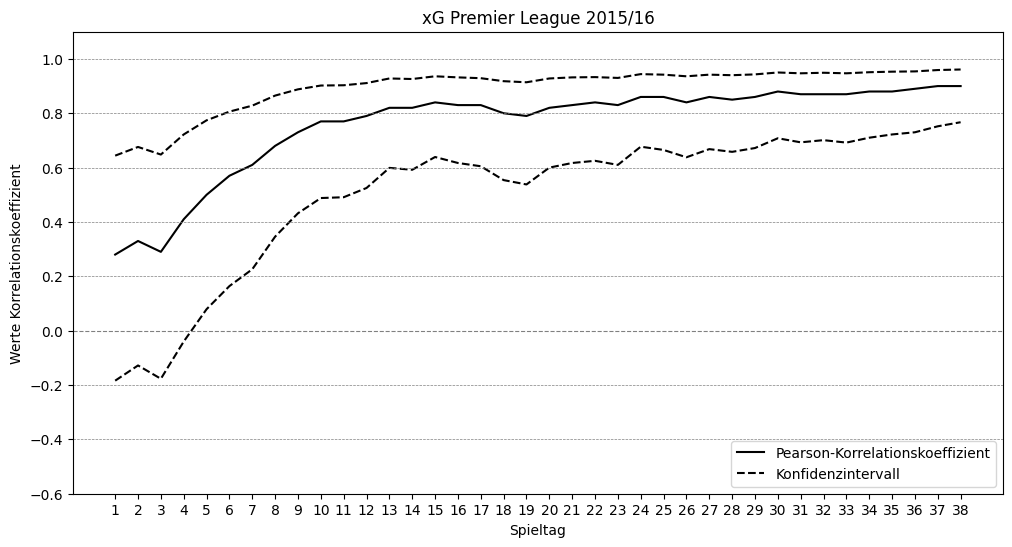

Diagram was saved succesfully /Users/andreas/Desktop/xG_Spieltag_Korrelation_Premier League.png


In [7]:
# Standard style (white background)
plt.style.use("default")

# Extract relevant data from DataFrame
spieltag_values = results_pear_df["Spieltag"].astype(int).tolist()
correlation_values = results_pear_df["Pearson Punktekorrelation"].tolist()
confidence_upper_value = results_pear_df["Konfidenzintervall upper Pearson"].tolist()
confidence_lower_value = results_pear_df["Konfidenzintervall lower Pearson"].tolist()

# Create diagram
plt.figure(figsize=(12, 6))
plt.plot(spieltag_values, correlation_values, linestyle='-', label='Pearson-Korrelationskoeffizient', color='black')
plt.plot(spieltag_values, confidence_upper_value, linestyle='dashed', label='Konfidenzintervall', color='black')
plt.plot(spieltag_values, confidence_lower_value, linestyle='dashed', label='', color='black')

# Set title
plt.title(f"xG {wettbewerbsname} 2015/16", color='black')

# Set axis titles
plt.xlabel("Spieltag", color='black')
plt.ylabel("Werte Korrelationskoeffizient", color='black')

# Set horizontal lines
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0.8, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0.6, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0.4, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0.2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y=-0.2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-0.4, color='gray', linestyle='--', linewidth=0.5)

plt.xticks(spieltag_values, rotation=0, color='black')
plt.yticks(color='black')

# Set boundaries
plt.ylim(-0.6, 1.1)

# Set legend
plt.legend(loc='lower right')

# Export diagram
desktop_path = os.path.expanduser("~/Desktop")
diagramm_path = os.path.join(desktop_path, f"xG_Spieltag_Korrelation_{wettbewerbsname}.png")
plt.savefig(diagramm_path, dpi=300, bbox_inches='tight', facecolor='white')

# Show diagram
plt.show()

print(f"Diagram was saved succesfully {diagramm_path}")
